In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
file_list=[
    {
        "vehicle_name": "Chrysler Pacifica 2018",
        "dbc_name": "opendbc/chrysler_pacifica_2017_hybrid.dbc",
        "steer_brake_acc": [258, 284, 308],
        "file_name": "exported_csvs/6fb4948a7ebe670e_2019-11-12--00-35-53.bz2.csv"
    },
    {
        "vehicle_name": "Toyota Prius Prime 2020",
        "dbc_name": "opendbc/toyota_prius_2017_pt_generated.dbc",
        "steer_brake_acc": [37, 166, 581], # acc input looks strange
        "file_name": "exported_csvs/eb378db0873da597_2020-02-29--11-50-42--0--rlog.bz2.csv"
    },
    {
        "vehicle_name": "Acura ILX",
        "dbc_name": "opendbc/acura_ilx_2016_can_generated.dbc",
        "steer_brake_acc": [342, 420, 304], # acc input looks strange
        "file_name": "exported_csvs/rlog.bz2.csv"
    },    
]

In [4]:
file_path = "exported_csvs/rlog.bz2.csv"
sequences = list()
df = pd.read_csv(file_path, header=0)
values = df.values

In [5]:
len(values)

10882

In [6]:
targets = np.ones(len(values))*342

In [7]:
targets

array([342., 342., 342., ..., 342., 342., 342.])

In [8]:
from sklearn import preprocessing

x = df.values #returns a numpy array
columns = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = columns

In [9]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [10]:
df

,145,342,398,399,819,821,304,316,344,380,...,888,923,773,985,929,1034,1029,1064,1365,busTime
0,0.517419,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.517419,0.999405,0.810548,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000090
2,0.517419,0.999405,0.810571,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000188
3,0.517419,0.999405,0.810571,0.002274,1.0,1.000000,5.800570e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000283
4,0.517419,0.999405,0.810501,0.002152,1.0,1.000000,5.881886e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,0.517135,0.999329,0.810432,0.993683,1.0,0.966322,3.936869e-03,0.000001,7.135548e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999628
10878,0.517135,0.999329,0.810432,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999716
10879,0.517135,0.999329,0.810455,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999811
10880,0.517135,0.999329,0.810455,0.993591,1.0,0.966322,3.952128e-03,0.000001,7.111097e-15,9.909291e-07,...,1.0,0.001432,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999911


In [11]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def create_X_y(df, num_samples, sample_length):
    X = np.zeros([num_samples, sample_length])
    y = np.zeros(num_samples)
    for i in range(num_samples):
        # Randomly choose which signal to write from
        signal_index = randint(0,df.shape[1]-1)
        chunk = []
        #print(signal_index)
        starting_point = randint(0,df.shape[0]-sample_length)
        
        for j in range(sample_length):
            # Since signal is very long, only a snippet is taken
            X[i][j] = df.iat[j+starting_point,signal_index]
            
        # Now create label based on what signal id we saved from    
        if df.columns[signal_index] == "342": #steering value for acura ilx
            np.append(y,1)
            y[i]=1
        else:
            y[i]=0
    return [X,y]
    

X, y = create_X_y(df, 1000, 784)


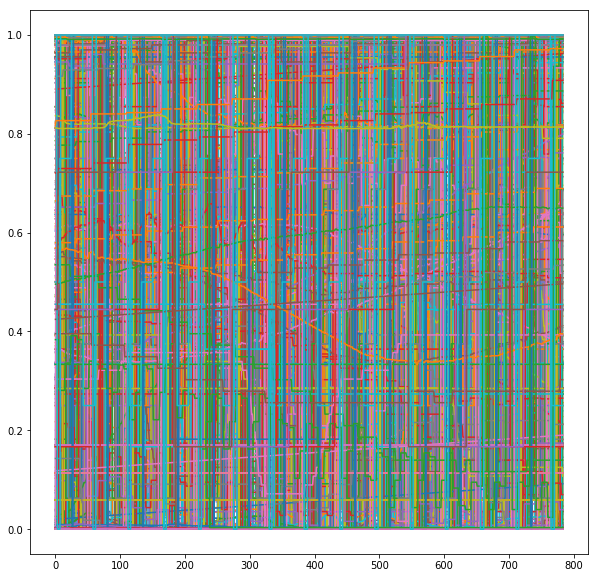

In [12]:
plt.figure(figsize=(10,10))
for i in range(0,X.shape[0]):
    plt.plot(X[i][:])
plt.show()

In [13]:
y

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D
model = Sequential()
#model.add(Conv1D(10, 5, input_shape=(784,)))
model.add(Dense(10, activation="sigmoid", input_shape=(784,)))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 7,872
Trainable params: 7,872
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

In [22]:
model.fit(X, y, batch_size=1, epochs=5)

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 1s 946us/sample - loss: 0.0996 - accuracy: 0.9850
Epoch 2/5
1000/1000 [==============================] - 1s 819us/sample - loss: 0.0731 - accuracy: 0.9860
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0695 - accuracy: 0.9860
Epoch 4/5
1000/1000 [==============================] - 1s 785us/sample - loss: 0.0648 - accuracy: 0.9860
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0617 - accuracy: 0.9860


In [9]:
from sklearn.model_selection import train_test_split


In [10]:
X_train, X_test, y_train, y_test = train_test_split(values, targets, test_size=0.2)

In [11]:
len(X_train)

8705

In [48]:
# FIXME: Prepare sequence somehow and adapt LSTM model to fit it
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dense(1, activation="sigmoid"))

NameError: name 'seq_len' is not defined